In [1]:
import numpy as np
import matplotlib
import scipy
import sklearn
import skimage
import networkx
import sys

from build_similarity_graph import *
from generate_data import *
from image_segmentation import *
from spectral_clustering import *
from utils import *

## 1. Graph construction

[[1.         0.95307138 0.96142444 ... 0.53586096 0.59787697 0.        ]
 [0.95307138 1.         0.88054464 ... 0.62866335 0.70104232 0.        ]
 [0.96142444 0.88054464 1.         ... 0.         0.         0.        ]
 ...
 [0.53586096 0.62866335 0.         ... 1.         0.99147855 0.88991759]
 [0.59787697 0.70104232 0.         ... 0.99147855 1.         0.84196641]
 [0.         0.         0.         ... 0.88991759 0.84196641 1.        ]]


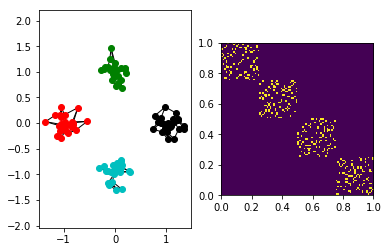

In [2]:
#Generating data
example=blobs(100,n_blobs=4)

#Building and printing eps similarity graph
g_eps=build_similarity_graph(X=example[0],k=0,eps=0.5)
print(g_eps)

#Building and plotting a K-NN graph
plot_similarity_graph(example[0],example[1],k=3)

### 1.1

The parameter is used to set the coordinates of a point so that it is far from the others. 
Since it is placed on the x-axis, and has a $x$ equal to the maximum of all coordinates of the other points plus *gen_pam*, its minimum distance to the other points is superior to *gen_pam*.

### 1.2

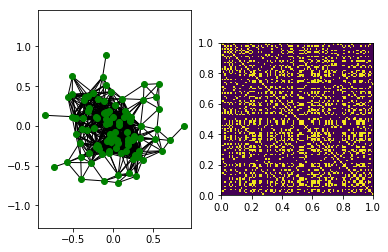

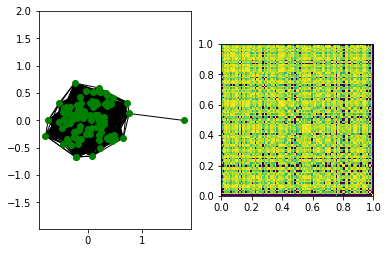

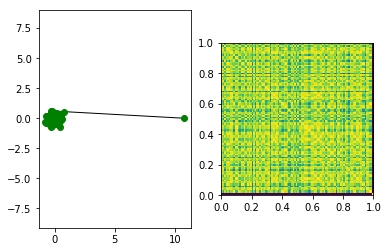

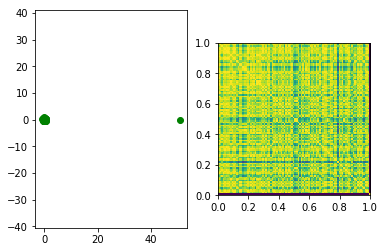

In [3]:
#Testing the function for different parameters gen_pam 
#(How_to_choose_epsilon has been modified so that it can be passed as an argument)

how_to_choose_epsilon(0)
how_to_choose_epsilon(1)
how_to_choose_epsilon(10)
how_to_choose_epsilon(50)

When we change the parameter *gen_pam* of *worst_case_blob* in *how-to_choose_epsilon*, we see different shapes of graphs and one outlier : the higher *gen_pam*, the further the outlier goes.

If the parameter is very large, the outlier is not connected to the other points anymore (cut by the $eps$ threshold).

### 1.3

The *two_moons* function of *generate_data* has been slightly modified since one of the points was assigned to the wrong cluster (when we have the index *int(num_samples / 2)*.

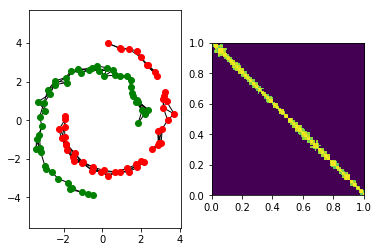

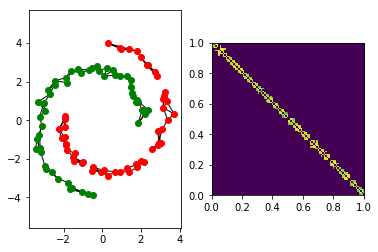

In [4]:
mo=two_moons(100)

#Plotting an epsilon graph
plot_similarity_graph(mo[0],mo[1],k=0,eps=0.75)

#Plotting a KNN graph
plot_similarity_graph(mo[0],mo[1],k=3)

In a dataset, when the points of a cluster are closer to their neighbors than to the points of the other clusters, an *eps* graph might be more adapted : with a KNN and a samll *k* we might not connect points of the same clusters, with a big *k* you might link a point to points of another cluster... Whereas with an *eps* graph, choosing *eps* equal to the minimum distance between the 2 clusters should work.

It is even more visible in the following case :

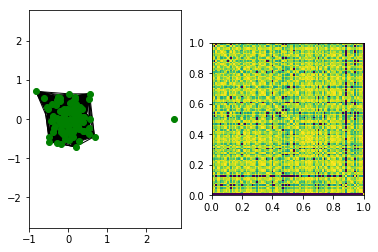

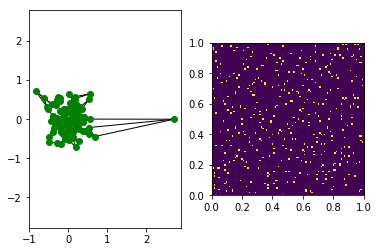

In [5]:
wb=worst_case_blob(100,2)

#Plotting an epsilon graph
plot_similarity_graph(wb[0],wb[1],k=0,eps=0.5)

#Plotting a KNN graph
plot_similarity_graph(wb[0],wb[1],k=3)

It also depends on the goal : if it is to isolate outliers, $eps$ would be a good option whereas the K-NN would systematicaly link it to other points. But if the goal is to have an unique cluster, the epsilon threshold graph will either not take points into account (high $eps$), either tend to be complete (low $eps$).

## 2. Spectral Clustering

### 2.1

**In the *spectral_clustering* function** 

We chose to compute the assignement a K-Means clustering on the chosen eigenvectors, to know how to cut the graph.


Note : the function *plot_clustering_result* from *utils.py* as been modified to display bigger figures

In [6]:
# Data from "two_blobs_clustering"
X, Y = blobs(600, n_blobs=2, blob_var=0.15, surplus=0)
num_classes = len(np.unique(Y))

In [7]:
"""
Choose parameters
"""     
k = 301 #to make sure that the graph is connected
var = 1.0  # exponential_euclidean's sigma^2

laplacian_normalization = 'unn'

# build laplacian
W = build_similarity_graph(X, var=var, k=k)
L = build_laplacian(W) #(default: unnormalized)

**We look at the eigenvalues to see the first eigenvalues that are strictly positive (or relatively to the others of value $10^{-n}$)**

*In general*: We choose the eigenvectors that correspond to information on how to segment the points. With *n* being the number of clusters, those vectors are the *n* first strictly positives ones and they are used to choose how we cut (*n-1* cuts) the graph to assign labels to the points respecting the clusters (i.e minimizing the cut of the graphs).

c:\users\alixa\appdata\local\programs\python\python35\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


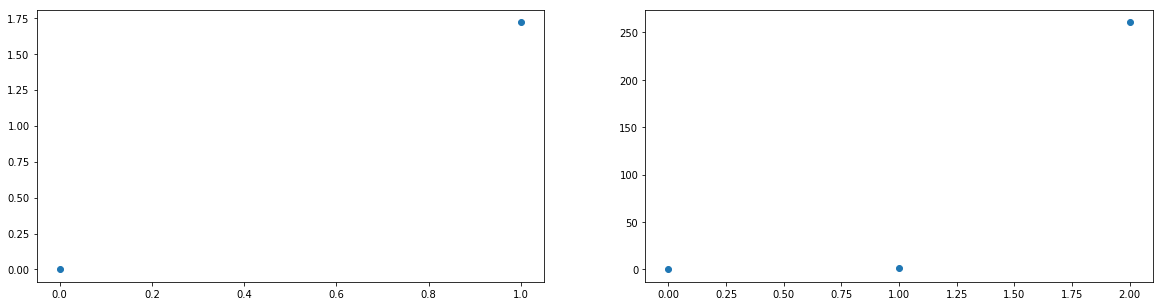

In [8]:
eig_val,eig_vec=scipy.linalg.eig(L)

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(np.sort(eig_val)[:2],'o')
plt.subplot(1,2,2)
plt.plot(np.sort(eig_val)[:3],'o')

*In our case*: By looking at the first eigen values plotted, we see that the first 1 is 0 whereas the second one is much higher. The 2nd high value means that the graphs is not easily separable in two components, due to all the edges between the two. However, since we know it CAN be separated in 2, which is also shown by the jump between the 2nd and 3rd eigenvalue, we choose the second one (index 1).

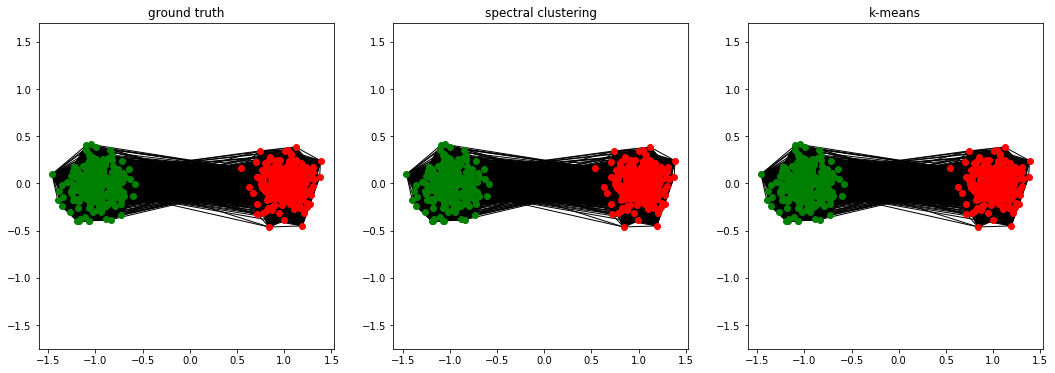

In [9]:
chosen_eig_indices = [1]

# run spectral clustering
Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes=num_classes)

# Plot results
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

### 2.2

In [10]:
"""
Choose parameters
"""     
k = 5 #we do not want a connected graph
var = 1.0  # exponential_euclidean's sigma^2

laplacian_normalization = 'unn'

# build laplacian
W = build_similarity_graph(X, var=var, k=k)
L = build_laplacian(W) #(default: unnormalized)

c:\users\alixa\appdata\local\programs\python\python35\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


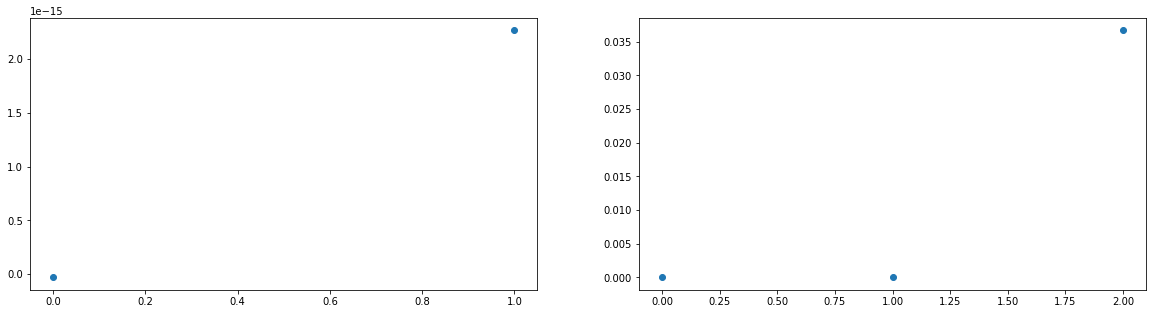

In [11]:
eig_val,eig_vec=scipy.linalg.eig(L)

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(np.sort(eig_val)[:2],'o')
plt.subplot(1,2,2)
plt.plot(np.sort(eig_val)[:3],'o')

*In our case*: Since we have data well separated, the second eigenvalue is really small. However, we see a huge relative jump between the 2nd and 3rd value. That means that the graph is easily separable into 2 connected components, but not 3. Therefore we choose the 2nd eigenvalue.

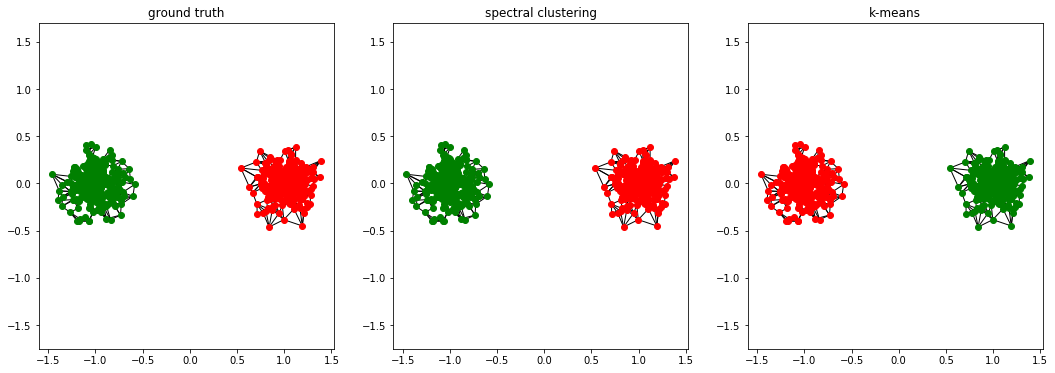

In [12]:
chosen_eig_indices = [1]

# build laplacian
W = build_similarity_graph(X, var=var, k=k)
L = build_laplacian(W) #(default: unnormalized)
                 
# run spectral clustering
Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes=num_classes)

# Plot results
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

### 2.3
We completed the *spectral_clustering_adaptative_function*.


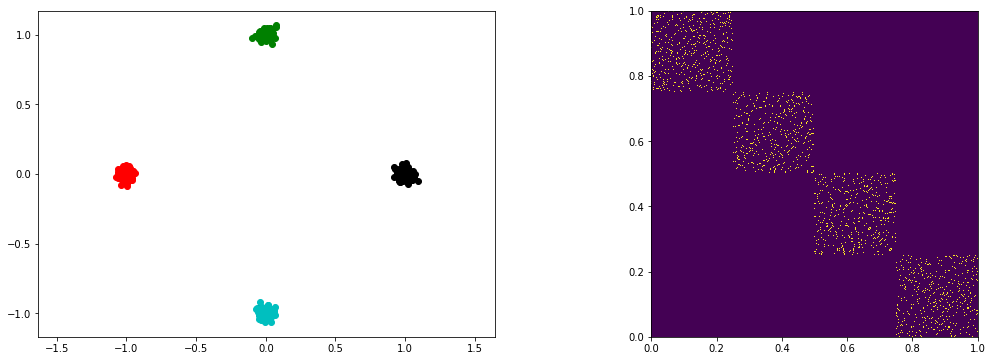

In [13]:
# Generating the data
blobs_4_X, blobs_4_Y = blobs(400, n_blobs=4, blob_var=0.03)

#Building a KNN graph
W_knn=build_similarity_graph(blobs_4_X,k=5)

# Plotting manually the results so that it is bigger
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plot_edges_and_points(blobs_4_X,blobs_4_Y,W_knn)
    
plt.subplot(1,2,2)
plt.imshow(W_knn,extent=[0, 1, 0, 1])
plt.show()


# Not using this to display bigger figures
#plot_similarity_graph(blobs_4_X,blobs_4_Y,k=5)

**Plotting the eigenvalues**

c:\users\alixa\appdata\local\programs\python\python35\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


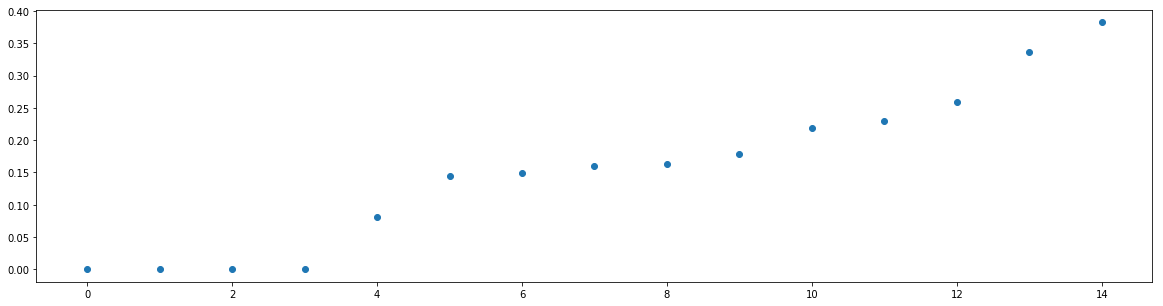

In [14]:
L = build_laplacian(W_knn) #(default: unnormalized)

eig_val,eig_vec=scipy.linalg.eig(L)

plt.figure(figsize=(20,5))
plt.plot(np.sort(eig_val)[:15],'o')
plt.show()

The function *choose_eig_function* (it was named *choose_eigenvalues* before, has been changed) has been modified to select eigenvectors according to the following rule :<br> 
We select the eigenvectors corresponding to the strictly positive eigenvalues before the first bend (jump in values) (hence the eigenvalue of index 0 is excluded, being equal to 0). 

*Note* : For datasets easily separables in *n* clusters, they correspond to the eigenvalues of index *1* to *n-1*.


**It was done by installing and importing the package ruptures, which have functions to find jumps in data**

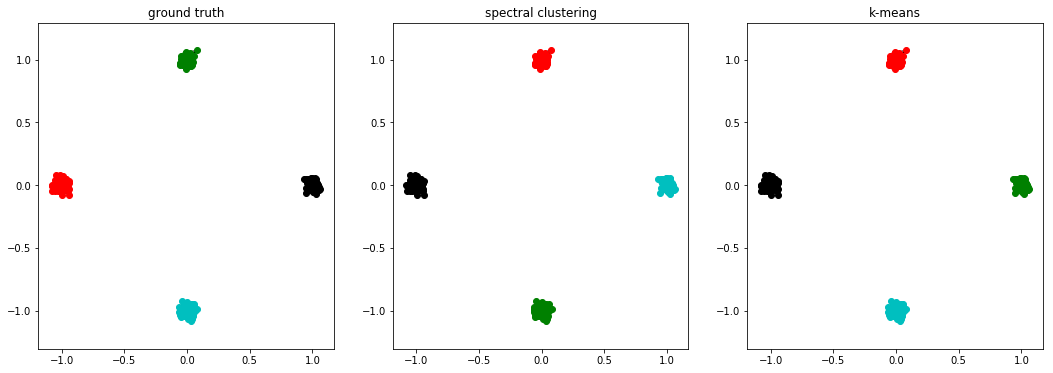

In [25]:
### Results with the adaptive spectral_clustering ###
num_classes=4

# run spectral clustering
Y_rec = spectral_clustering_adaptive(L,num_classes=num_classes )

# Plot results
plot_clustering_result(blobs_4_X, blobs_4_Y, L, Y_rec, KMeans(num_classes).fit_predict(blobs_4_X))

### 2.4

Data with more variance

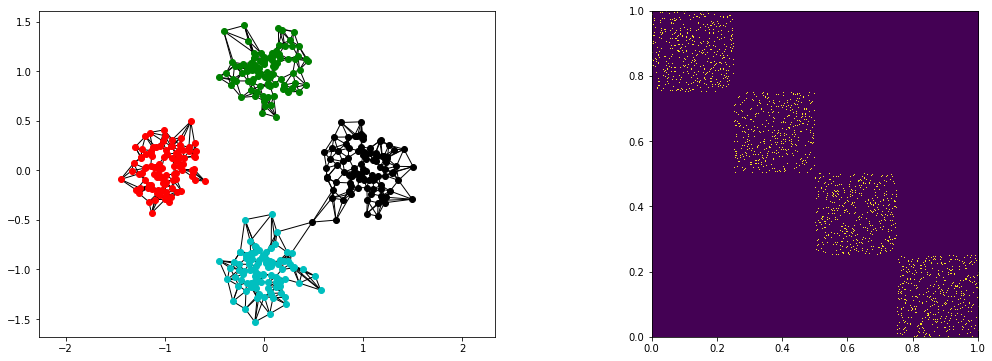

In [40]:
# Generating the data
blobs_4_X, blobs_4_Y = blobs(400, n_blobs=4, blob_var=0.20)

#Building a KNN graph
W_knn=build_similarity_graph(blobs_4_X,k=5)

# Plotting manually the results so that it is bigger
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plot_edges_and_points(blobs_4_X,blobs_4_Y,W_knn)
    
plt.subplot(1,2,2)
plt.imshow(W_knn,extent=[0, 1, 0, 1])
plt.show()


c:\users\alixa\appdata\local\programs\python\python35\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


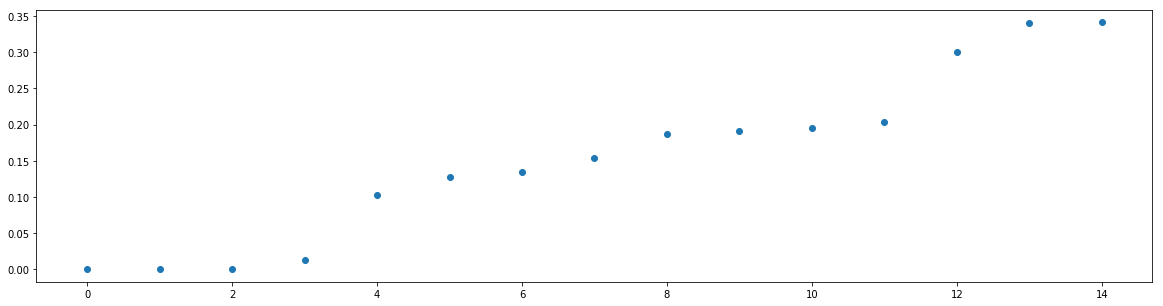

In [41]:
L = build_laplacian(W_knn) #(default: unnormalized)

eig_val2,eig_vec2=scipy.linalg.eig(L)

plt.figure(figsize=(20,5))
plt.plot(np.sort(eig_val2)[:15],'o')
plt.show()

In [42]:
print(choose_eig_function(eig_val2))

[1 2 3]


We see that the 4th eigenvalue is a bit higher than in the previous case. It means that the data is less easily separable in 4 distinct components, and it is due to the edge linking 2 of the blobs and the fact that they are closer.

However, the *choose_eig_function* still does its job, giving the first 3 positive eigenvectors to help find the 3 cuts of the graphs that will give 4 clusters.

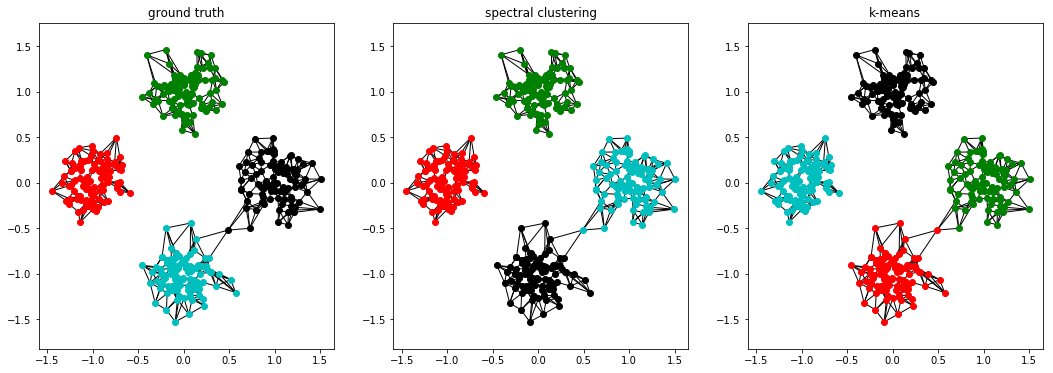

In [43]:
### Results with the adaptive spectral_clustering ###
num_classes=4

# run spectral clustering
Y_rec = spectral_clustering_adaptive(L,num_classes=num_classes )

# Plot results
plot_clustering_result(blobs_4_X, blobs_4_Y, L, Y_rec, KMeans(num_classes).fit_predict(blobs_4_X))

We also notice that the point near the center of the edge between the two components is correctly identified by the spectral clustering but not by the K-means.

### 2.5

I used K-mans for all assignement. It works well because the components' means are well separated. In general K-means would not work for clusters with similar center (like concentric circles).

### 2.6

As said before, it can help to know if the data is easily separable. If the last eigenvectors taht we choose (before the jump in values) is really higher than the others, it means that the components are close to each other and the cost of cutting the graph to separate them is higher. 

### 2.7

The functions *two_moons_clustering* and *point_and_circle_clustering* have been completed so that the eigenvalues are computed and the eigenvectors automatically chosen according to the values of the actual eigenvalues (with the function *choose_eig_function*).

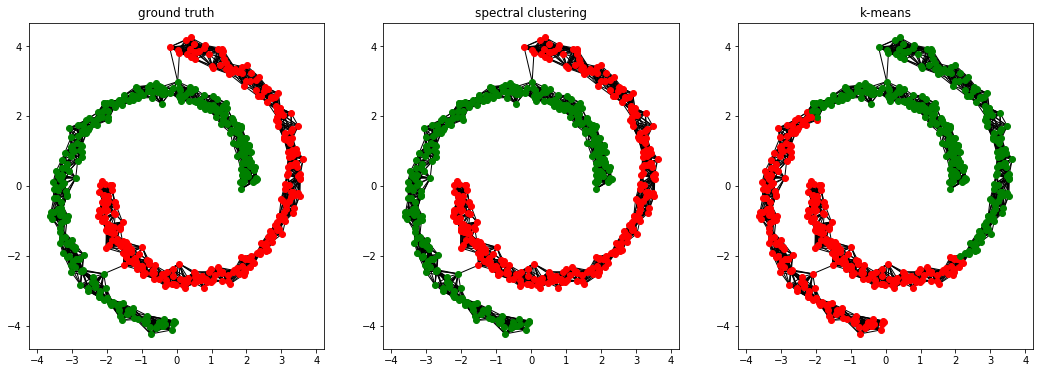

In [2]:
two_moons_clustering()

We see that the K-means could not separate the two components, whereas the spectral clustering worked perfectly. 

The reason is that the K-Means algorithm is based on finding the centers of the components, which are really close in this case. Therefore it will just cut the whole cloud of points in half.

### 2.8

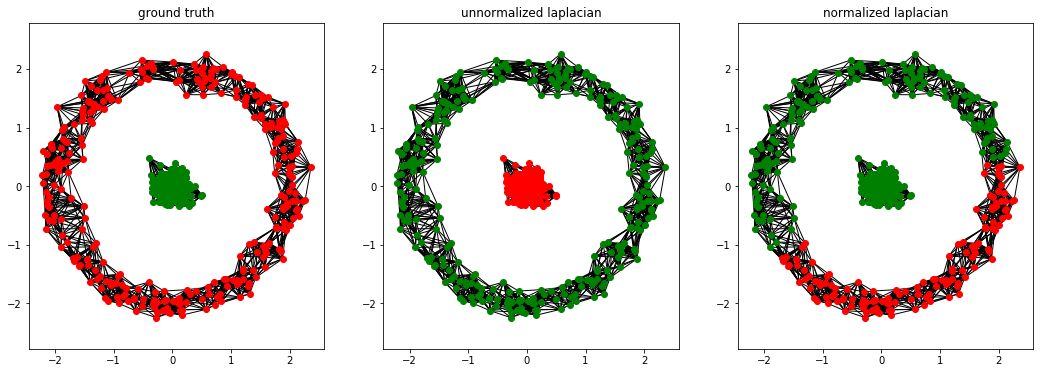

In [2]:
point_and_circle_clustering()

The random_walk normalized laplacian could not separate the two components while the normal one could.

The reason is that the unnormalized Laplacian aims to minimize the Ratio Cut to get balanced number of vertices in the components, while the RW normalized Laplacian looks at the volume. Since in the data the two components have the same number of vertices, but different volumes (the points in the center being much closer to each other), the unnormalized version works better.

### 2.9

The function *parameter_sensitivity* has been modified so that the eigenvectors are automatically chosen by the *choose_eig_function*.

We test it for a KNN-graph with k in [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50]

c:\users\alixa\appdata\local\programs\python\python35\lib\site-packages\sklearn\utils\validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


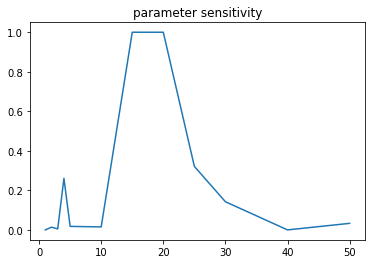

In [2]:
parameter_sensitivity()

The spectral clustering is quite dependent on the parameters used in the construction of the similarities matrix. We see here that the performances jumps up from almost 0 to 1 between k=10 and k=15, and then goes back down for a bigger k. It is therfore critical to choose the right one, or test different parameters to get optimal performances.

### 2.10
The simplest way to evaluate the clustering would be to use the Min Cut. However, we should not use that because in many cases the solution to that problem would be to isolate one vertex or have really unbalanced components.

To take this issue into account, we could use the Ratio Cut or the Normalized Cut instead.

## 3. Image Segmentation

In [1]:
import numpy as np
import matplotlib
import scipy
import sklearn
import skimage
import networkx
import sys

from build_similarity_graph import *
from generate_data import *
from image_segmentation import *
from spectral_clustering import *
from utils import *

Building the similarity graph using a K-nn, with k=75...
Done.
Computing the Laplacian...
Done.
Number of clusters : 3


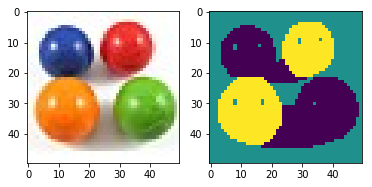

Number of clusters : 5


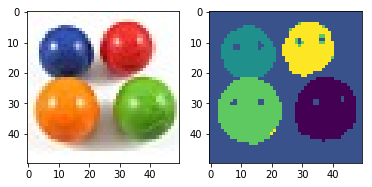

Number of clusters : 7


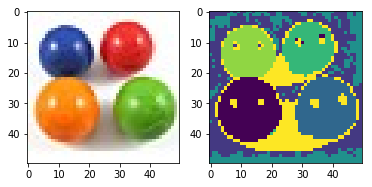

In [2]:
image_segmentation(input_img='four_elements.bmp')

Building the similarity graph using a K-nn, with k=80...
Done.
Computing the Laplacian...
Done.
Number of clusters : 2


c:\users\alixa\appdata\local\programs\python\python35\lib\site-packages\sklearn\utils\validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


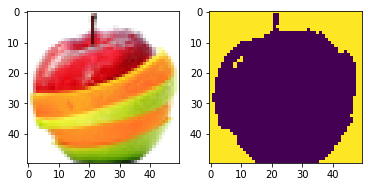

Number of clusters : 4


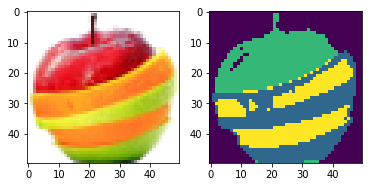

Number of clusters : 6


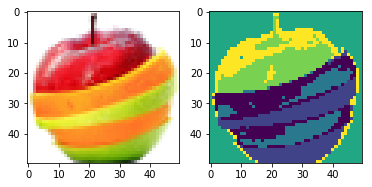

In [2]:
image_segmentation(input_img='fruit_salad.bmp')

We see a godd clustering for K=4. However, we notice that the lightest part of the top orange slice is classified like the light green.

If what is interseting for us is to cluster by color without bias from light and shadows, an idea would be to preprocess the data of the pixels to keep the proportion of red, green or blue. This way, a darker or lighter pixel of the same hue would be considered the same.

### 3.2
To reduce the computational and occupationnal cost, we could :
- Use sparse matrices. Since the similarity matrix is mainly filled by zeros, it could reduce a lot the space necessary to stroe the data, and reduce computation time by avoiding operations on zero elements.
- Approximate by forming sets of similar points. We would then consider a similarity matrix built with one representative point from each set, run the Spectral Clustering on this smaller matrix and extend the result found on the representative points to the rest of the points in their set.

### 3.3
I used the *eig* function from *scipy.linalg* to compute the eigenvalues and vectors.

We could get different values, because the order might be different, and the eigenvectors corresponding to an eigenvalue are not unique (different scalings possible). Moreover, *scipy.sparse.linalg.eigs* does not work well when the matrix is not positive definite, and it is based on the Lanczos algorithm which only approximates the eigenvalues and does not do well with samll eigenvalues that could be rounded-off.

However, *scipy.sparse.linalg.eigs* is of lower order of complexity : $O(nkl)$ vs $O(n^3)$ with $n$ the number of nodes, $k$ the number of non-zero elements per row in the matrix and $l$ the number of steps in the algorithm. It would therefore be more efficient for large matrices.